# Part 3: CG-rich promoter eSTRs form transcription-inducing DNA secondary structures

#### Figures:
* **Figure 3A**: Schematic of G4 repeats at promoters (not in notebook)
* **Figure 3B**: G4 motifs direction of effect
* **Figure 3C**: G4 overall free energy
* **Figure 3D**: G4 change in energy
* **Figure 3E**: G4 r
* **Figure 3F**: G4 two examples (CSTB and multi-allelic)

TODO: update this when completed

#### Supplementary Figures:

#### Supplementary Tables:

#### Statistics:


In [1]:
# Set up
%pylab inline
%run params.py

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns

############ Set up paths #############
SAVEPLOT = True
PREFIX = "eSTR-G4"
FIGPREFIX = "Figure3"
DATADIR = os.path.join(BASEDATADIR, PREFIX)
RESULTSDIR = os.path.join(BASERESULTSDIR, PREFIX)

############ Load data #############
estrs = pd.read_csv(os.path.join(BASERESULTSDIR, "eSTR-calling","SuppTable_ALLCAUSAL.csv"))
geneannot = pd.read_csv(GENEANNOT)
geneannot["gene"] = geneannot["gene.id"].apply(lambda x: x.split(".")[0])
estrs = pd.merge(estrs, geneannot[["gene", "gene.strand"]], on=["gene"])

causal = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]

mfold = pd.read_csv("/storage/mgymrek/gtex/mfold/all_strs_mfold_summary_v2.tab", sep="\t", \
                    names=["chrom","str.start","str.end","type","strand", "mfold_r", "mfold_mean", "mfold_min","mfold_max"])
mfold["chrom"] = mfold["chrom"].apply(lambda x: "chr"+str(x))
mfold["str.start"] = mfold["str.start"]+1
mfold = mfold.drop_duplicates()
hipref = pd.read_csv(HIPREF, sep="\t", names=["chrom","str.start","str.end","motif"], usecols=[0,1,2,4])
hipref["str.start"] = hipref["str.start"]+1
mfold = pd.merge(hipref, mfold, on=["chrom","str.start"])

all_mfold = pd.read_csv("/storage/mgymrek/gtex/mfold/all_strs_mfold.tab", sep="\t")
all_mfold = all_mfold.drop_duplicates()

Populating the interactive namespace from numpy and matplotlib


In [2]:
g4_motifs = set(causal[causal["motif"].apply(lambda x: "GGG" in x or "CCC" in x or x=="C" or x =="G")]["motif"])
"""
    g4_motifs = ["AGGG", "CCCG",\
                "ACCC", "GGGT", \
                "AGGGG", "CCCCT", \
                "C", "G", \
                "ACCC", "GGGT", \
                "CCCG", "CGGG", \
                "CCCCG", "CGGGG", \
                 "ACCCC", "GGGGT", \
                "AAGGG", "CCCTT", \
                "AGCCC", "GGGCT", \
                "AGGGC", "GCCCT", \
                "ACCCCC", "GGGGGT", \
                "AGCCCC", "GGGGCT", \
                "CCCCCG", "CGGGGG", \
                "CCCGG", "CCGGG", \
                "AGAGGG", "CCCTCT", \
                "CCCCGG", "CCGGGG"]
"""
def IsG4(motif):
    return motif in g4_motifs

def IsGControl(motif):
    g_motifs = ["CCG", "CGG"]
    return motif in g_motifs

for x in (sorted(list(g4_motifs))):
    num=(causal[causal["motif"]==x].shape[0])
    print("%s:%s"%(x, num))

AACCCC:1
AACCCT:1
ACCCCC:1
AGAGGG:2
AGCCCC:2
AGCCCG:1
AGGG:2
AGGGTT:1
ATGCCC:1
C:20
CCCCCG:1
CCCCG:4
CCCCT:1
CCCG:2
CCCGG:2
CCCT:3
CCCTCT:3
CCCTG:1
CCCTGG:1
CCCTT:1
CCGGG:1
CCGGGG:3
CCTGGG:1
CGGGCT:1
CGGGG:6
CGGGGG:3
CTGGG:1
CTGGGG:4
G:20
GGGGT:1
GGGGTT:1


In [3]:
allstrs = pd.read_csv(os.path.join(BASEDATADIR, "eSTR-enrich", "all_analyzed_strs.tab"), sep="\t", names=["chrom","str.start"])
ref = pd.read_csv(os.path.join(BASEDATADIR, "annotations", "hg19.hipstr_reference_annot_v2.bed"), sep="\t")
ref = pd.merge(ref, allstrs, on=["chrom","str.start"])
ref["str.start"] = ref["str.start"]+1
refcausal = pd.merge(ref, causal, on=["chrom","str.start"])

In [5]:
print(np.mean(refcausal[refcausal["motif_x"].apply(IsG4)]["5utr"]>0))
print(np.mean(refcausal[refcausal["motif_x"].apply(IsGControl)]["5utr"]>0))

0.060240963855421686
0.782608695652174


# Figure 3B: Effect size direction

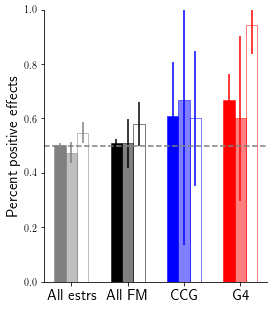

In [6]:
# Get direction+stderr for:
# G4 causal all, G4 causal promoter
# all causal, all promoter
# http://www.pmean.com/01/zeroevents.html for estimating conf interval when no events

labels = []
colors = []
ecolors = []
alphas = []
dirs = []
stderrs = []
nums = []
xvals = []
pvals = []

w = 0.2
dist = 3000
tss_bins = [(-1000000, 10000000), (-1*dist, 0), (0, dist)]
binlabels = ["ALL", "promoter", "downstream"]
bincolors = [ "white", "darkgray", "lightgray"]
classcolors = ["gray","black","blue","red"]
binalphas = [1, 0.5, 0]

g4 = causal[causal["motif"].apply(IsG4)]
gcontrol = causal[causal["motif"].apply(IsGControl)]
dfs = [ estrs, causal, gcontrol, g4]
dflabels = ["All estrs", "All FM", "CCG", "G4"]

ind = 0
for df in dfs:
    dflabel = dflabels[ind]
    for tbin in tss_bins:
        l = binlabels[tss_bins.index(tbin)]
        df_bin = df[(df["dist.tss"]>=tbin[0]) & (df["dist.tss"]<tbin[1])]
        perc = np.mean(df_bin["beta"]>0)
        dirs.append(perc)
        if perc < 1:
            stderrs.append(1.96*np.sqrt(perc*(1-perc)/df_bin.shape[0]))
        else:
            stderrs.append(3/df_bin.shape[0])
        nums.append(df_bin.shape[0])
        pvals.append(scipy.stats.binom_test(perc*df_bin.shape[0], df_bin.shape[0]))
    colors.extend([classcolors[ind]]*3)
    alphas.extend(binalphas)
    ind += 1
    #colors.extend(bincolors)
    #ecolors.extend(bincolors)
    xvals.extend([ind, ind+w, ind+2*w])
    labels.append(dflabel)

rgba_colors = np.zeros((len(xvals), 4))
for i in range(len(colors)):
    rgba_colors[i, 0:3] = matplotlib.colors.to_rgba(colors[i])[0:3]
rgba_colors[:, 3] = alphas

fig = plt.figure()
fig.set_size_inches((4, 5))
ax = fig.add_subplot(111)
ax.bar(xvals, dirs, color=rgba_colors, edgecolor=colors, linewidth=0.5, yerr=stderrs, ecolor=colors,  width=w)
ax.axhline(y=0.5, linestyle="dashed", color="gray")
ax.set_ylim(bottom=0, top=1);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks([xvals[i] for i in range(len(xvals)) if i%3 == 1])
ax.set_xticklabels(labels, size=15);
ax.set_ylabel("Percent positive effects", size=15)
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "%s_G4Direction.pdf"%FIGPREFIX));

In [7]:
print("G4")
print(nums[9:12])
print(dirs[9:12])
print(pvals[9:12])

print("Grich")
print(nums[6:9])
print(dirs[6:9])
print(pvals[6:9])

print("all causal")
print(nums[3:6])
print(dirs[3:6])
print(pvals[3:6])

print("all strs")
print(nums[0:3])
print(dirs[0:3])
print(pvals[0:3])

G4
[93, 10, 18]
[0.6666666666666666, 0.6, 0.9444444444444444]
[0.001712764422400238, 0.7539062500000002, 0.00014495849609375]
Grich
[23, 3, 15]
[0.6086956521739131, 0.6666666666666666, 0.6]
[0.4048728942871095, 1.0, 0.6072387695312501]
all causal
[3474, 118, 140]
[0.5086355785837651, 0.5084745762711864, 0.5785714285714286]
[0.33350752887740354, 0.9267042229477828, 0.07555082875265655]
all strs
[25561, 665, 630]
[0.5034623058565784, 0.47368421052631576, 0.5476190476190477]
[0.2709664693644683, 0.1873078067596973, 0.018671398852210613]


# Figure 3C/D Free energy

In [21]:
#x = g4[g4["dist.tss"].apply(abs)<10000].sort_values("dist.tss")[["motif","beta","dist.tss"]]
#np.mean(x[x["dist.tss"]<0]["motif"].apply(lambda x: "CCC" in x))



DNA:+
mfold mean
CCG vs. all
3.05347647149478
8.3610028474258755e-140
G4 vs. all
1.3077132631995192
3.467137286923638e-54
FM vs. all
1.1110615865169071
4.638307009686138e-17
FM vs. all-CCG
1.121601229671665
0.17063206051527696
FM vs. all-G4
1.5639866253147408
6.315218905369831e-08
mfold diff
CCG vs. all
10.955155802201299
1.7065777573821638e-83
G4 vs. all
2.6586184779298216
1.1370320496400088e-155
FM vs. all
1.3779230958799646
0.12362326554522732
FM vs. all-CCG
2.12210069317241
0.03778747406553913
FM vs. all-G4
2.257339786679025
0.0005331219204556843
mfold r
CCG vs. all
-4.690377023024073
3.2677961552754685e-91
G4 vs. all
-0.16752272951337147
6.392291470821445e-36
FM vs. all
0.8113593845382552
0.1597706198993138
FM vs. all-CCG
1.112081535435445
0.5416769255255988
FM vs. all-G4
13.039977886864987
1.978463457008233e-06
All-STRs:1.969800313927646e-70:0.4668528734026953
All-eSTRs:2.4489010687069427e-25:0.45575573402792846
All-FM:0.010799938251678128:0.4710071210579858
CCG-all:1.258310901

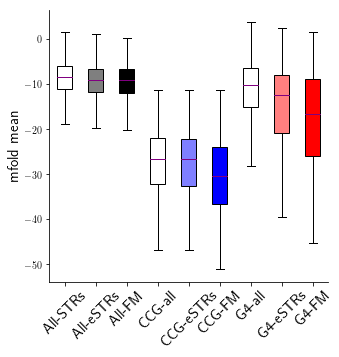

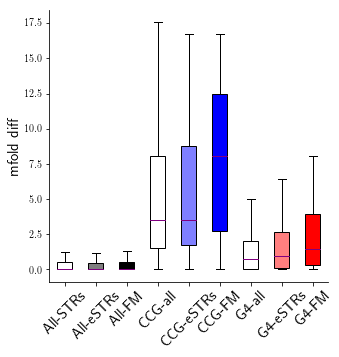

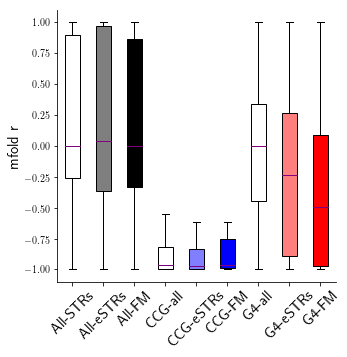

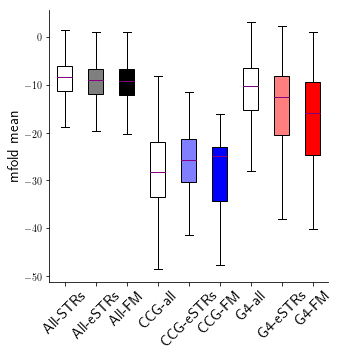

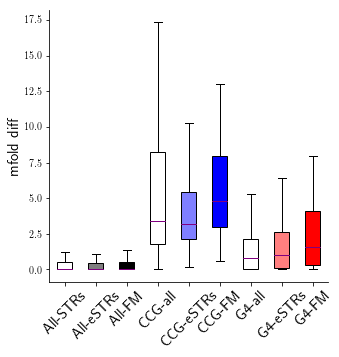

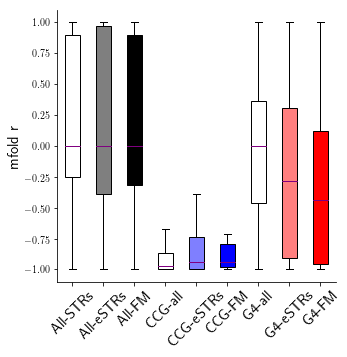

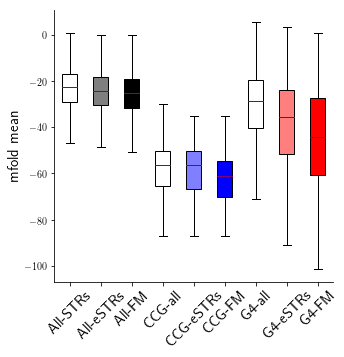

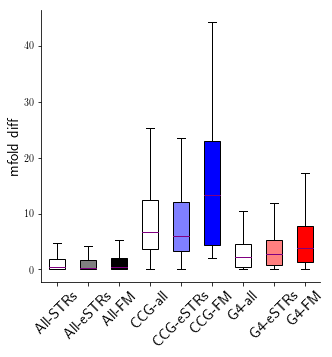

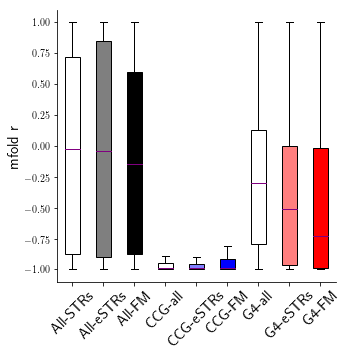

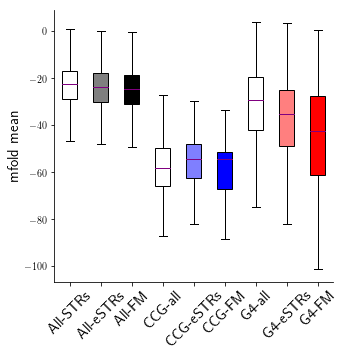

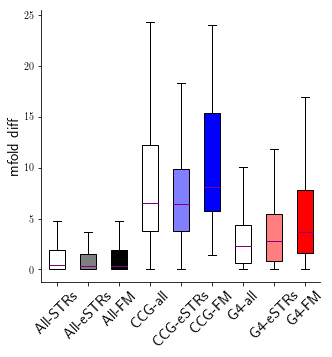

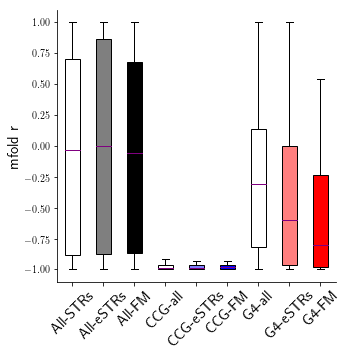

In [36]:
mfold["mfold_diff"] = mfold["mfold_max"]-mfold["mfold_min"]
mfold["mfold_r.dir"] = (mfold["mfold_r"]>0).apply(int)

mfold_e = pd.merge(estrs, mfold[["chrom","str.start","mfold_diff","mfold_r.dir","mfold_r","mfold_mean","type","strand"]], on=["chrom","str.start"])

def GetMin(ll):
    minval = np.inf
    for l in ll:
        if min(l)<minval: minval = min(l)
    return minval

def GetMax(ll):
    maxval = -1*np.inf
    for l in ll:
        if max(l)>maxval: maxval = max(l)
    return maxval

def PlotEnergy(mfold_e, mfold, col="mfold_mean", fname=None, binom=False):
    mfold_e = mfold_e[~np.isnan(mfold_e[col])].copy()
    mfold = mfold[~np.isnan(mfold[col])].copy()
    labels = ["All-STRs", "All-eSTRs", "All-FM", \
                            "CCG-all","CCG-eSTRs","CCG-FM", \
                            "G4-all","G4-eSTRs", "G4-FM"]
    data = []
    # All STRs
    data.append(list(mfold[col]))
    data.append(list(mfold_e[col]))
    data.append(list(mfold_e[mfold_e["causal"]][col]))
    
    # CCG/GCC
    data.append(list(mfold[mfold["motif"].apply(IsGControl)][col]))
    data.append(list(mfold_e[mfold_e["motif"].apply(IsGControl)][col]))
    data.append(list(mfold_e[mfold_e["motif"].apply(IsGControl) & mfold_e["causal"]][col]))
    
    # G4
    data.append(list(mfold[mfold["motif"].apply(IsG4)][col]))
    data.append(list(mfold_e[mfold_e["motif"].apply(IsG4)][col]))
    data.append(list(mfold_e[mfold_e["motif"].apply(IsG4) & mfold_e["causal"]][col]))

    print ("CCG vs. all")
    print(np.mean(data[3])/np.mean(data[0]))
    print(scipy.stats.ks_2samp(data[0], data[3])[1])
    print ("G4 vs. all")
    print(np.mean(data[6])/np.mean(data[0]))
    print(scipy.stats.ks_2samp(data[0], data[6])[1])
    
    print("FM vs. all")
    print(np.mean(data[2])/np.mean(data[0]))
    print(scipy.stats.ks_2samp(data[0], data[2])[1])
    print("FM vs. all-CCG")
    print(np.mean(data[5])/np.mean(data[3]))
    print(scipy.stats.ks_2samp(data[3], data[5])[1])
    print("FM vs. all-G4")
    print(np.mean(data[8])/np.mean(data[6]))
    print(scipy.stats.ks_2samp(data[6], data[8])[1])

    if binom:
        for i in range(len(data)):
            bindata = [int(item>0) for item in data[i]]
            p = scipy.stats.binom_test(sum(bindata), len(bindata), p=0.5)
            print("%s:%s:%s"%(labels[i], p, 1-np.mean(bindata)))
    fig = plt.figure()
    fig.set_size_inches((5, 5))
    ax = fig.add_subplot(111)
    bplot = ax.boxplot(data, sym="", patch_artist=True, medianprops={"color": "purple"})
    
    colors = ["black"]*3+["blue"]*3+["red"]*3
    alphas = [0, 0.5, 1]*3
    rgba_colors = np.zeros((len(colors), 4))
    for i in range(len(colors)):
        rgba_colors[i, 0:3] = matplotlib.colors.to_rgba(colors[i])[0:3]
    rgba_colors[:, 3] = alphas
    
    #colors = ["white","gray","black"]*3
    for patch, color in zip(bplot['boxes'], rgba_colors):
        patch.set_facecolor(color)
    #if col == "mfold_mean":
    #    ax.set_ylim(bottom=-50, top=5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticklabels(labels, rotation=45, size=15)
    #ax.set_yticklabels([int(item) for item in ax.get_yticks()], size=12)
    ax.set_ylabel(col.replace("_", " "), size=15)
    if fname is not None: fig.savefig(fname)

def GetRightStrand(x, strand):
    if strand == "+": return x["strand"]==x["gene.strand"]
    else: return x["strand"]!=x["gene.strand"]
    
for ntype in ["DNA", "RNA"]:
    for strand in ["+", "-"]:
        edata = mfold_e[(mfold_e["type"]==ntype) & (mfold_e.apply(lambda x: GetRightStrand(x, strand), 1))]
        adata = mfold[(mfold["type"]==ntype) & (mfold["strand"]==strand) ]
        
        print("\n\n%s:%s"%(ntype, strand))
        print("==============")
        print("mfold mean")
        fname = None
        if SAVEPLOT: fname = os.path.join(RESULTSDIR, "%s_meanmfold_%s_%s.pdf"%(FIGPREFIX, ntype, strand))
        PlotEnergy(edata, adata, col="mfold_mean", fname=fname)
        print("==============")
        print("mfold diff")
        fname = None
        if SAVEPLOT: fname = os.path.join(RESULTSDIR, "%s_diffmfold_%s_%s.pdf"%(FIGPREFIX, ntype, strand))
        PlotEnergy(edata, adata, col="mfold_diff", fname=fname)
        print("==============")
        print("mfold r")
        fname = None
        if SAVEPLOT: fname = os.path.join(RESULTSDIR, "%s_rmfold_%s_%s.pdf"%(FIGPREFIX, ntype, strand))
        PlotEnergy(edata, adata, col="mfold_r", fname=fname, binom=True)

# Figure 3F: Examples

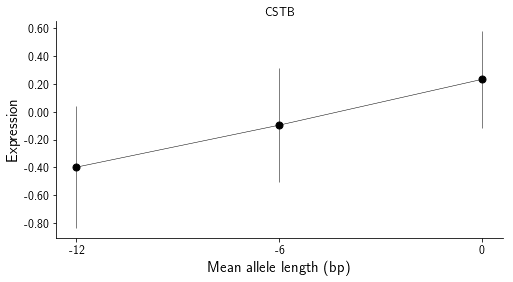

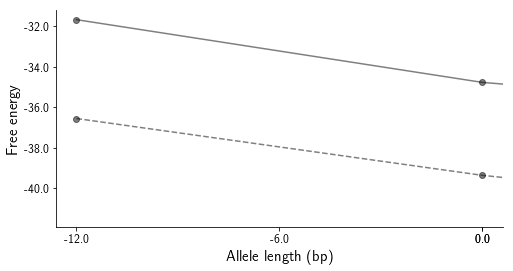

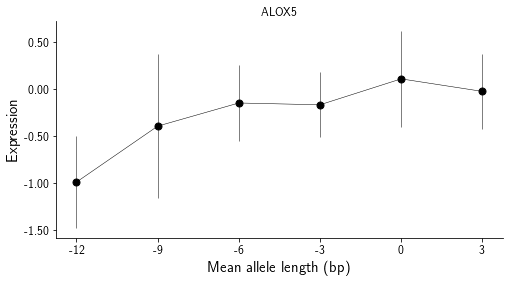

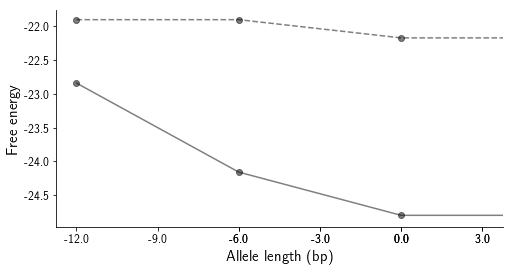

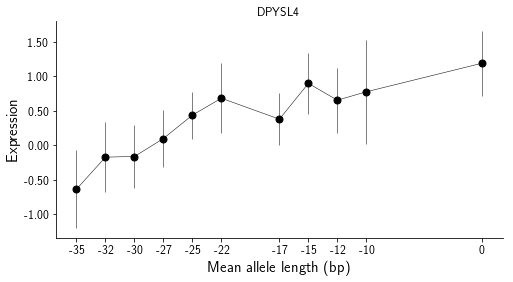

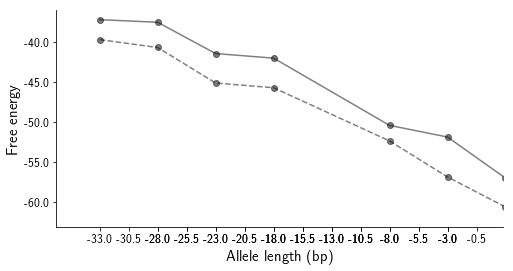

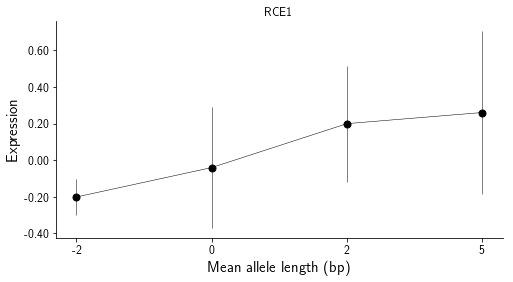

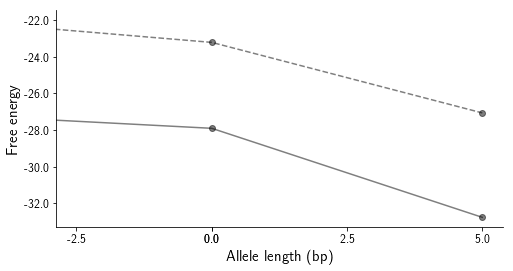

In [15]:
def PlotEnergies(allele_lengths, energies_coding, energies_noncoding, \
                 diploid_lengths, diploid_energies_coding, diploid_energies_noncoding, \
                 reflen=0, xlim=xlim, fname=None):
    allele_lengths = [item-reflen for item in allele_lengths]
    diploid_lengths = [item-reflen for item in diploid_lengths]
        
    fig = plt.figure()
    fig.set_size_inches((8, 4))
    ax = fig.add_subplot(111)
    ax.plot(allele_lengths, energies_coding, color="black", alpha=0.5, marker="o")
    ax.plot(allele_lengths, energies_noncoding, color="black", alpha=0.5, marker="o", linestyle="dashed")
    #ax.scatter(diploid_lengths, diploid_energies_coding, color="red")
    #ax.scatter(diploid_lengths, diploid_energies_noncoding, color="blue")
    ax.set_xlabel("Allele length (bp)", size=15)
    ax.set_ylabel("Free energy", size=15)
    ax.set_xticks(diploid_lengths)
    ax.set_xticklabels(diploid_lengths, size=12)
    ax.set_yticklabels(ax.get_yticks(), size=12)
    ax.set_xlim(xlim)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    if fname is not None: fig.savefig(fname)
    
def ExtractData(gene, chrom, start, tissue):
    if "(" in tissue: tissue = tissue.split("(")[0]
    vcf = "/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz"
    # Pull out STR genotypes
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2+$3}' > str_genotypes.tab"""%(chrom.replace("chr",""), start, start, vcf)
    os.system(cmd)
    # Pull out gene expression
    expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/%s/Corr_Expr.csv"%tissue
    colnum = open(expr,"r").readline().split(",").index('"' + gene + '"')+2
    cmd = """cat %s | cut -d',' -f 1,%s | grep -v ENSG > expr.tab"""%(expr, colnum)
    os.system(cmd)

def Expand(x):
    buf=0.2
    if x<0: return x-buf
    else: return x+buf

def GetExpr(gene, tissue, chrom, start, end):
    ExtractData(gene, chrom, start, tissue)
    strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
    strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))
        
    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    data = pd.merge(strgt, expr) 
    
    rmgts = []
    for gt in sorted(list(set(data["str"]))):
        if data[data["str"]==gt].shape[0] <3: rmgts.append(gt)
    data = data[data["str"].apply(lambda x: x not in rmgts)]

    means = data.groupby("str", as_index = False).agg({"expr": np.mean})
    means = means.sort_values("str")
    sds = data.groupby("str", as_index=False).agg({"expr": np.std})
    sds["sdev"] = sds["expr"]
    means = pd.merge(means, sds[["str","sdev"]], on=["str"])
    return means[["str","expr","sdev"]]
  
def PlotExpr(gene, tissue, chrom, start, end, locus, fname=None):
    esum = GetExpr(gene, tissue, chrom, start, end).sort_values("str")
    esum["str"] = esum["str"]/2.0
    fig = plt.figure()
    fig.set_size_inches((8, 4))
    ax = fig.add_subplot(111)
    (_, caps, _) = ax.errorbar(esum["str"], esum["expr"], yerr=esum["sdev"], color="black", capthick=0.5, marker="o", markersize='7', linewidth=0.5)
    
    ax.set_xlabel("Mean allele length (bp)", size=15)
    ax.set_ylabel("Expression", size=15)
    ax.set_xticks(esum["str"])
    ax.set_xticklabels([int(item) for item in ax.get_xticks()], size=12)
    ax.set_yticklabels(["%.2f"%item for item in ax.get_yticks()], size=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    ax.set_title(locus)
    if fname is not None: fig.savefig(fname)
    return plt.xlim() #Expand(min(esum["str"])), Expand(max(esum["str"]))
    
def ExtractMfold(all_mfold, chrom, pos):
    locus = "%s_%s-%s"%(chrom, pos, pos)
    m = all_mfold[all_mfold["locus"]==locus]
    m = m.groupby(["length","strand"], as_index=False).agg({"energy": np.mean}).sort_values("length")
    allele_lengths = list(m[m["strand"]=="+"]["length"])
    energies_coding = list(m[m["strand"]=="+"]["energy"])
    energies_noncoding = list(m[m["strand"]=="-"]["energy"])
    diploid_length = []
    diploid_energies_coding = []
    diploid_energies_noncoding = []

    for i in range(len(allele_lengths)):
        for j in range(i, len(allele_lengths)):
            diploid_length.append((allele_lengths[i]+allele_lengths[j])/2.0)
            diploid_energies_coding.append((energies_coding[i]+energies_coding[j])/2)
            diploid_energies_noncoding.append((energies_noncoding[i]+energies_noncoding[j])/2)

    return allele_lengths, energies_coding, energies_noncoding, \
        diploid_length, diploid_energies_coding, diploid_energies_noncoding

example_loci = []
# CSTB
gene="ENSG00000160213.5"
tissue="Muscle-Skeletal"
chrom="chr21"
pos=45196326
end=45196360
strand = "-"
example_loci.append(["CSTB", gene, tissue, chrom, pos, end, 42, strand])

# ALOX5
gene="ENSG00000012779.6"
tissue="Esophagus-Mucosa"
chrom="chr10"
pos=45869548
end=45869585
strand = "+"
example_loci.append(["ALOX5", gene, tissue, chrom, pos, end, end-pos+1, strand])

# DPYSL4
gene="ENSG00000151640.8"
tissue="Cells-Transformedfibroblasts"
chrom="chr10"
pos=134000825
end=134000897
strand = "+"
example_loci.append(["DPYSL4", gene, tissue, chrom, pos, end, end-pos+1, strand])

# RCE1
gene="ENSG00000173653.3"
tissue="Lung"
chrom="chr11"
pos=66610830
end=66610848
strand = "+"
example_loci.append(["RCE1", gene, tissue, chrom, pos, end, 20, strand])

for el in example_loci:
    locus, gene, tissue, chrom, pos, end, reflen, strand = el
    if SAVEPLOT:
        efname = os.path.join(RESULTSDIR, "%s_%s_expr.pdf"%(FIGPREFIX, locus))
        mfname = os.path.join(RESULTSDIR, "%s_%s_energy.pdf"%(FIGPREFIX, locus))
    else:
        efname = None
        mfname = None
    allele_lengths, energies_coding, energies_noncoding, diploid_lengths, diploid_energies_coding, diploid_energies_noncoding = \
        ExtractMfold(all_mfold, chrom.replace("chr",""), pos)
    xlim = PlotExpr(gene, tissue, chrom, pos, end, locus, fname=efname)

    if strand == "+":    
        PlotEnergies(allele_lengths, energies_coding, energies_noncoding, \
             diploid_lengths, diploid_energies_coding, diploid_energies_noncoding, \
             reflen=reflen, xlim=xlim, fname=mfname)
    else:
        PlotEnergies(allele_lengths, energies_noncoding, energies_coding, \
             diploid_lengths, diploid_energies_noncoding, diploid_energies_coding, \
             reflen=reflen, xlim=xlim, fname=mfname)


# Composite plots

In [13]:
all_strs = pd.read_csv("/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv", sep="\t",
                      usecols=[0,1,3])
all_strs["str.start"] = all_strs["str.start"]+1
all_strs = pd.merge(all_strs, hipref, on=["chrom","str.start"])[["chrom","str.start","str.end","gene","motif"]]
geneannot["gene"] = geneannot["gene.id"]
all_strs["id"] = all_strs.apply(lambda x: "%s:%s"%(x["gene"], x["str.start"]), 1)
all_strs["x"] = "x"
all_strs = pd.merge(all_strs, geneannot, on=["gene"])
all_strs["dist.tss"] = all_strs.apply(lambda x: (x["str.start"]-x["gene.start"]) if x["gene.strand"]=="+" else (x["gene.stop"]-x["str.start"]), 1)

In [14]:
# Make peak annotation files
causal["id"] = causal.apply(lambda x: "%s:%s:%.2f"%(x["gene.name"], x["str.start"], x["score"]), 1)
causal["x"] = "x"
estrs["id"] = estrs.apply(lambda x: "%s:%s:%.2f"%(x["gene.name"], x["str.start"], x["score"]), 1)
estrs["x"] = "x"

dist = 5000 # restrict to close to TSS


all_outfile = "/storage/mgymrek/gtex/homer-plots/annfiles/all_strs_tss.bed"
all_strs[(all_strs["dist.tss"].apply(abs)<=dist)][["chrom","str.start","str.end","id","x","gene.strand"]].to_csv(all_outfile, sep="\t", index=False, header=False)

causal_outfile = "/storage/mgymrek/gtex/homer-plots/annfiles/all_causal_estrs_tss.bed"
causal[(causal["dist.tss"].apply(abs)<=dist)][["chrom","str.start","str.end","id","x","gene.strand"]].to_csv(causal_outfile, sep="\t", index=False, header=False)

estr_outfile = "/storage/mgymrek/gtex/homer-plots/annfiles/all_estrs_tss.bed"
estrs[(estrs["dist.tss"].apply(abs)<=dist)][["chrom","str.start","str.end","id","x","gene.strand"]].to_csv(estr_outfile, sep="\t", index=False, header=False)

estr_g4_outfile = "/storage/mgymrek/gtex/homer-plots/annfiles/all_estrs_g4.bed"
estrs[estrs["motif"].apply(IsG4) & (estrs["dist.tss"].apply(abs)<=dist)][["chrom","str.start","str.end","id","x","gene.strand"]].to_csv(estr_g4_outfile, sep="\t", index=False, header=False)

causal_g4_outfile = "/storage/mgymrek/gtex/homer-plots/annfiles/all_causal_g4.bed"
causal[causal["motif"].apply(IsG4) & (causal["dist.tss"].apply(abs)<=dist)][["chrom","str.start","str.end","id","x","gene.strand"]].to_csv(causal_g4_outfile, sep="\t", index=False, header=False)

all_g4_outfile = "/storage/mgymrek/gtex/homer-plots/annfiles/all_strs_g4.bed"
all_strs[all_strs["motif"].apply(IsG4) & (all_strs["dist.tss"].apply(abs)<=dist)][["chrom","str.start","str.end","id","x","gene.strand"]].to_csv(all_g4_outfile, sep="\t", index=False, header=False)

estr_gctrl_outfile = "/storage/mgymrek/gtex/homer-plots/annfiles/all_estrs_gctrl.bed"
estrs[estrs["motif"].apply(IsGControl) & (estrs["dist.tss"].apply(abs)<=dist)][["chrom","str.start","str.end","id","x","gene.strand"]].to_csv(estr_gctrl_outfile, sep="\t", index=False, header=False)

causal_gctrl_outfile = "/storage/mgymrek/gtex/homer-plots/annfiles/all_causal_gctrl.bed"
causal[causal["motif"].apply(IsGControl) & (causal["dist.tss"].apply(abs)<=dist)][["chrom","str.start","str.end","id","x","gene.strand"]].to_csv(causal_gctrl_outfile, sep="\t", index=False, header=False)

all_gctrl_outfile = "/storage/mgymrek/gtex/homer-plots/annfiles/all_strs_gctrl.bed"
all_strs[all_strs["motif"].apply(IsGControl) & (all_strs["dist.tss"].apply(abs)<=dist)][["chrom","str.start","str.end","id","x","gene.strand"]].to_csv(all_gctrl_outfile, sep="\t", index=False, header=False)


/usr/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


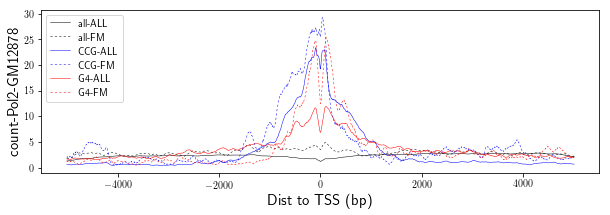

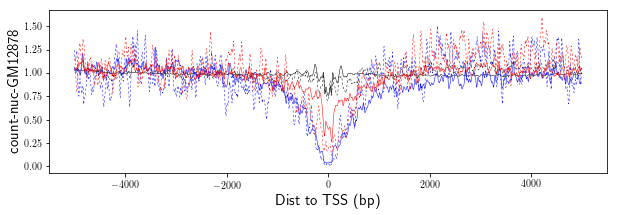

In [35]:
# Plot: All, CGG, G4 (all, fm estrs)
cols = ["dist", "count-S5-H1", "x", "y", \
       "count-S5-GM12878", "x","y", \
       "count-Pol2-H1", "x", "y", \
       "count-Pol2-GM12878", "x", "y", \
       "count-S2-GM12878", "x", "y", \
       "count-dnase-GM12878", "x", "y", \
       "count-nuc-GM12878", "x", "y"]

labels = ["all", "CCG", "G4"]
colors = ["black", "blue", "red"]

for col in ["count-Pol2-GM12878", "count-nuc-GM12878"]:
    fig = plt.figure()
    fig.set_size_inches((10, 3))
    ax = fig.add_subplot(111)

    for l in labels:
        if l == "all":
            aname = "taghist-pol2-all_strs_tss.txt"
            ename = "taghist-pol2-all_causal_estrs_tss.txt"
        elif l == "CCG":
            aname = "taghist-pol2-all_strs_gctrl.txt"
            ename = "taghist-pol2-all_causal_gctrl.txt"
        else:
            aname = "taghist-pol2-all_strs_g4.txt"
            ename = "taghist-pol2-all_causal_g4.txt"
    
        color = colors[labels.index(l)]
        adata = pd.read_csv(os.path.join("/storage/mgymrek/gtex/homer-plots/", aname), sep="\t")
        adata.columns = cols
        ax.plot(adata["dist"], adata[col], color=color, linestyle="solid", label="%s-ALL"%l, linewidth=0.5)
    
        edata = pd.read_csv(os.path.join("/storage/mgymrek/gtex/homer-plots/", ename), sep="\t")
        edata.columns = cols
        ax.plot(edata["dist"], edata[col], color=color, linestyle="dotted", label="%s-FM"%l, linewidth=0.5)
    if "Pol2" in col: ax.legend(loc="upper left")
    ax.set_xlabel("Dist to TSS (bp)", size=15)
    ax.set_ylabel(col, size=15)
    fig.savefig(os.path.join(RESULTSDIR, "%s_%s.pdf"%(FIGPREFIX, col)))